#  DMDW CASE STUDY

## Online User Behaviour Analysis — Graphical Model
## Dataset: social_media_vs_productivity.csv

## OVERVIEW
### This notebook performs EDA, preprocessing, unsupervised segmentation, and supervised modeling
### (K-NN, Random Forest, Logistic Regression, SVM) on the social_media_vs_productivity dataset.
### It also attempts Bayesian Network structure learning and HMM


## STEP 1: IMPORT LIBRARIES


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                                f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score


try:
    from pgmpy.models import DiscreteBayesianNetwork
    from pgmpy.estimators import HillClimbSearch, BDeu
    pgmpy_installed = True
except Exception:
    pgmpy_installed = False

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\pgmpy\utils\utils.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


## STEP 2: LOAD DATASET

In [2]:
DATA_PATH = 'social_media_vs_productivity.csv'
try:
    df = pd.read_csv(DATA_PATH)
    print('Dataset loaded:', DATA_PATH)
    print('Shape:', df.shape)
    display(df.head())
except FileNotFoundError:
    raise FileNotFoundError(f"{DATA_PATH} not found. Please upload the CSV to the notebook folder.")

Dataset loaded: social_media_vs_productivity.csv
Shape: (30000, 19)


,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,Male,Unemployed,4.180940,Facebook,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,False,False,4,11,21.927072,6.336688
1,46,Male,Health,3.249603,Twitter,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,True,True,2,25,0.000000,3.412427
2,32,Male,Finance,NaN,Twitter,57,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0,True,False,3,17,10.322044,2.474944
3,60,Female,Unemployed,NaN,Facebook,59,6.355027,2.916331,1.774869,6.0,6.052984,1.204540,1,False,False,0,4,23.876616,1.733670
4,25,Male,IT,NaN,Telegram,66,6.214096,8.868753,NaN,7.0,5.405706,1.876254,1,False,True,1,30,10.653519,9.693060


## STEP 3: DATA UNDERSTANDING

In [15]:
print('\n--- Data Snapshot ---')
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

# Basic stats for numeric columns
print('\nNumeric summary:')
display(df.describe().T)


--- Data Snapshot ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         27235 non-null  float64
 4   social_platform_preference      30000 non-null  object 
 5   number_of_notifications         30000 non-null  int64  
 6   work_hours_per_day              30000 non-null  float64
 7   perceived_productivity_score    28386 non-null  float64
 8   actual_productivity_score       27635 non-null  float64
 9   stress_level                    28096 non-null  float64
 10  sleep_hours                     27402 non-null  float64
 11  screen_time_before_sleep        27789 non-null  float64
 12  breaks_du

,count,mean,std,min,25%,50%,75%,max
age,30000.0,41.486867,13.835221,18.000000,30.000000,41.000000,53.000000,65.000000
daily_social_media_time,27235.0,3.113418,2.074813,0.000000,1.639566,3.025913,4.368917,17.973256
number_of_notifications,30000.0,59.958767,7.723772,30.000000,55.000000,60.000000,65.000000,90.000000
work_hours_per_day,30000.0,6.990792,1.997736,0.000000,5.643771,6.990641,8.354725,12.000000
perceived_productivity_score,28386.0,5.510488,2.023470,2.000252,3.757861,5.525005,7.265776,8.999376
actual_productivity_score,27635.0,4.951805,1.883378,0.296812,3.373284,4.951742,6.526342,9.846258
stress_level,28096.0,5.514059,2.866344,1.000000,3.000000,6.000000,8.000000,10.000000
sleep_hours,27402.0,6.500247,1.464004,3.000000,5.493536,6.498340,7.504143,10.000000
screen_time_before_sleep,27789.0,1.025568,0.653355,0.000000,0.528490,1.006159,1.477221,3.000000
breaks_during_work,30000.0,4.992200,3.173737,0.000000,2.000000,5.000000,8.000000,10.000000


## STEP 4: DATA CLEANING & PRE-PROCESSING
### - Handle missing values
### - Create target variable
### - Encode categorical variable

In [4]:
print('\n--- Data Cleaning & Preprocessing ---')
df_clean = df.copy()

# 1) Standardize column names (strip spaces)
df_clean.columns = [c.strip() for c in df_clean.columns]

# 2) Fill missing numeric values with median, categorical with mode
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

if len(num_cols) > 0:
    df_clean[num_cols] = pd.DataFrame(num_imputer.fit_transform(df_clean[num_cols]),
                                     columns=num_cols)
if len(cat_cols) > 0:
    df_clean[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(df_clean[cat_cols]),
                                      columns=cat_cols)

print(' Missing values handled (median/mode).')

# 3) Feature engineering: productivity gap and binary target
# If actual_productivity_score exists, create binary target: HighProductivity (1 if actual >= median)
if 'actual_productivity_score' in df_clean.columns:
    threshold = df_clean['actual_productivity_score'].median()
    df_clean['HighProductivity'] = (df_clean['actual_productivity_score'] >= threshold).astype(int)
    print(f" Created 'HighProductivity' target using median threshold = {threshold}")
else:
    # fallback: use perceived_productivity_score if actual missing
    if 'perceived_productivity_score' in df_clean.columns:
        threshold = df_clean['perceived_productivity_score'].median()
        df_clean['HighProductivity'] = (df_clean['perceived_productivity_score'] >= threshold).astype(int)
        print(f" Created 'HighProductivity' target using perceived median threshold = {threshold}")
    else:
        raise ValueError('No productivity score column found to create target variable.')

# 4) Encode categorical variables with LabelEncoder (store encoders in dict)
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

print(' Categorical encoding done.')

# 5) Final cols check
print('\nFinal columns:')
print(df_clean.columns.tolist())



--- Data Cleaning & Preprocessing ---
 Missing values handled (median/mode).
 Created 'HighProductivity' target using median threshold = 4.951741600417723
 Categorical encoding done.

Final columns:
['age', 'gender', 'job_type', 'daily_social_media_time', 'social_platform_preference', 'number_of_notifications', 'work_hours_per_day', 'perceived_productivity_score', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score', 'HighProductivity']



## STEP 5: EXPLORATORY DATA ANALYSIS (Plots)
### distributions, correlation heatmap, pairplots for key features and save figures.



--- Exploratory Data Analysis ---


<Figure size 1400x800 with 0 Axes>

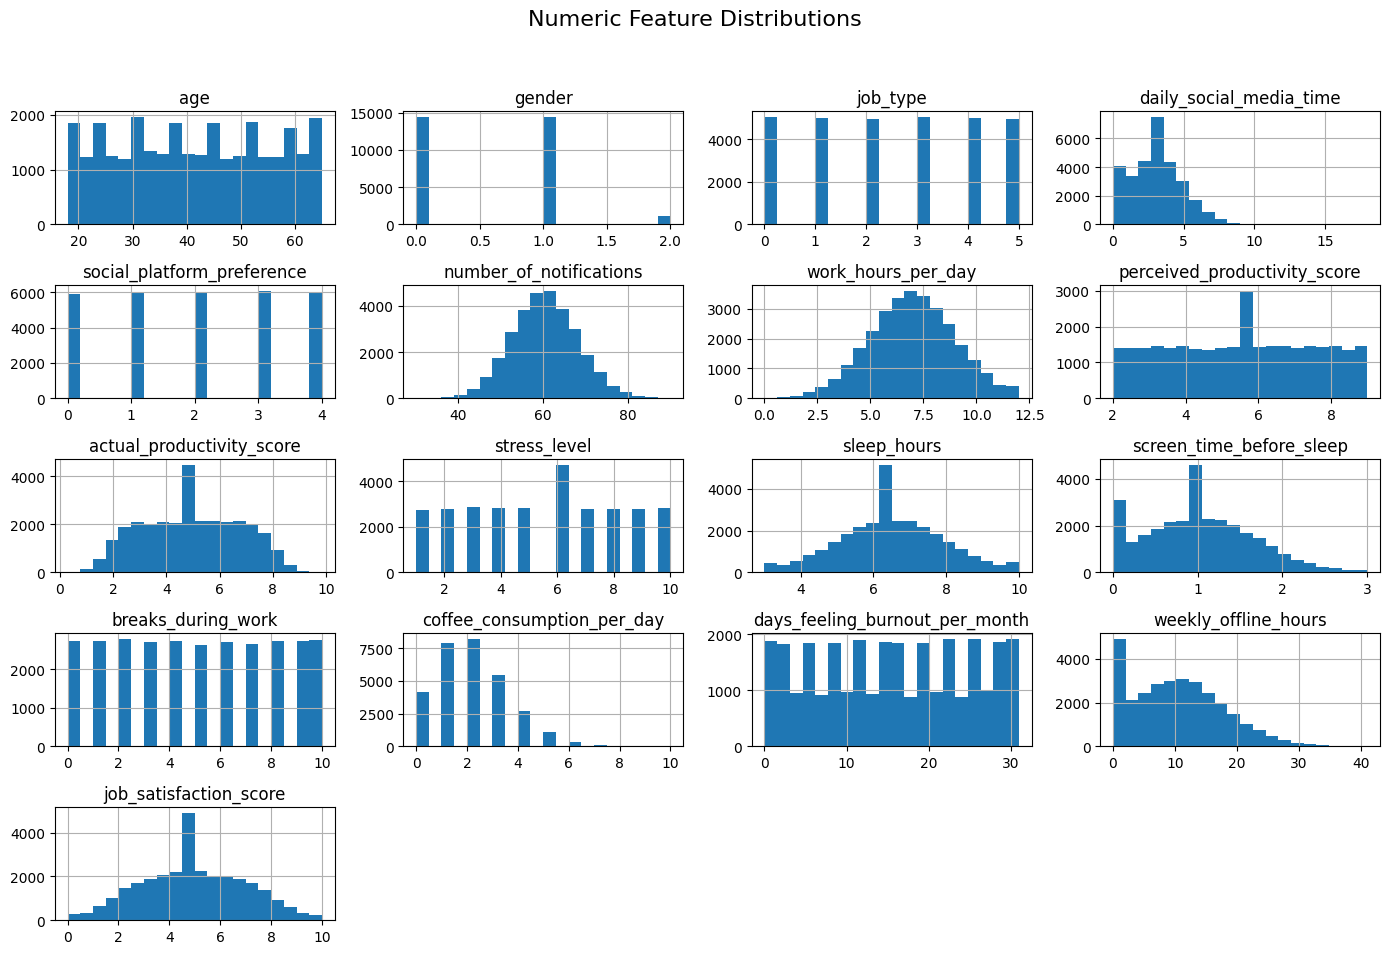

In [ ]:
print('\n--- Exploratory Data Analysis ---')

# Distribution plots for numeric features
numeric_features = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
# exclude target
if 'HighProductivity' in numeric_features:
    numeric_features.remove('HighProductivity')

plt.figure(figsize=(14, 8))
df_clean[numeric_features].hist(bins=20, figsize=(14, 10))
plt.suptitle('Numeric Feature Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('dist_numeric_features.png')
plt.show()


# Tips:
# X-Axis — value of the feature
# Y-Axis — how many people/data points fall in that value range

### Correlation heatmap


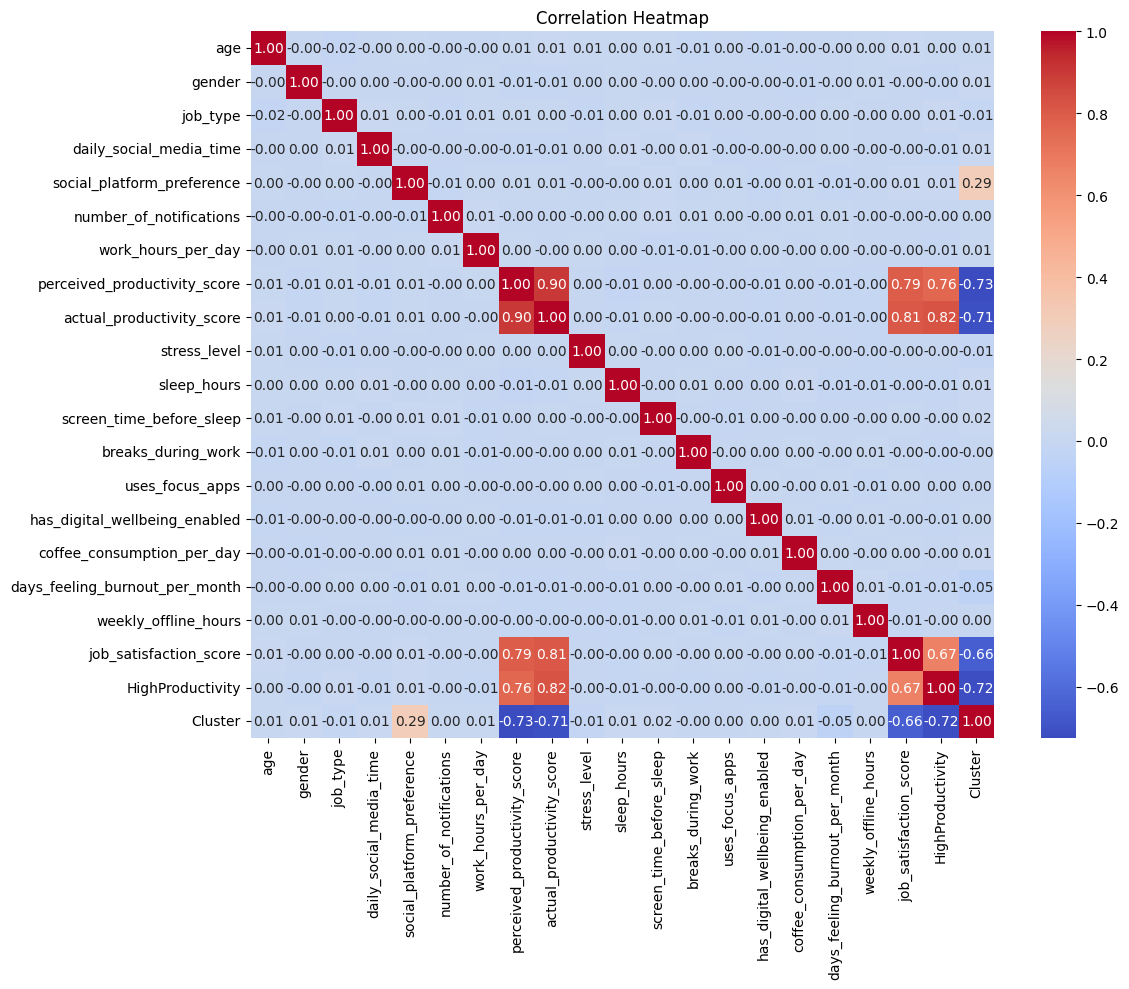

In [ ]:

plt.figure(figsize=(12, 10))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()


# Tips:
# +1-> means perfectly postive
# 0 -> no relation 
#-1 -> opposite reaction 


### Pairplot for selected features (limit to avoid heavy plotting)


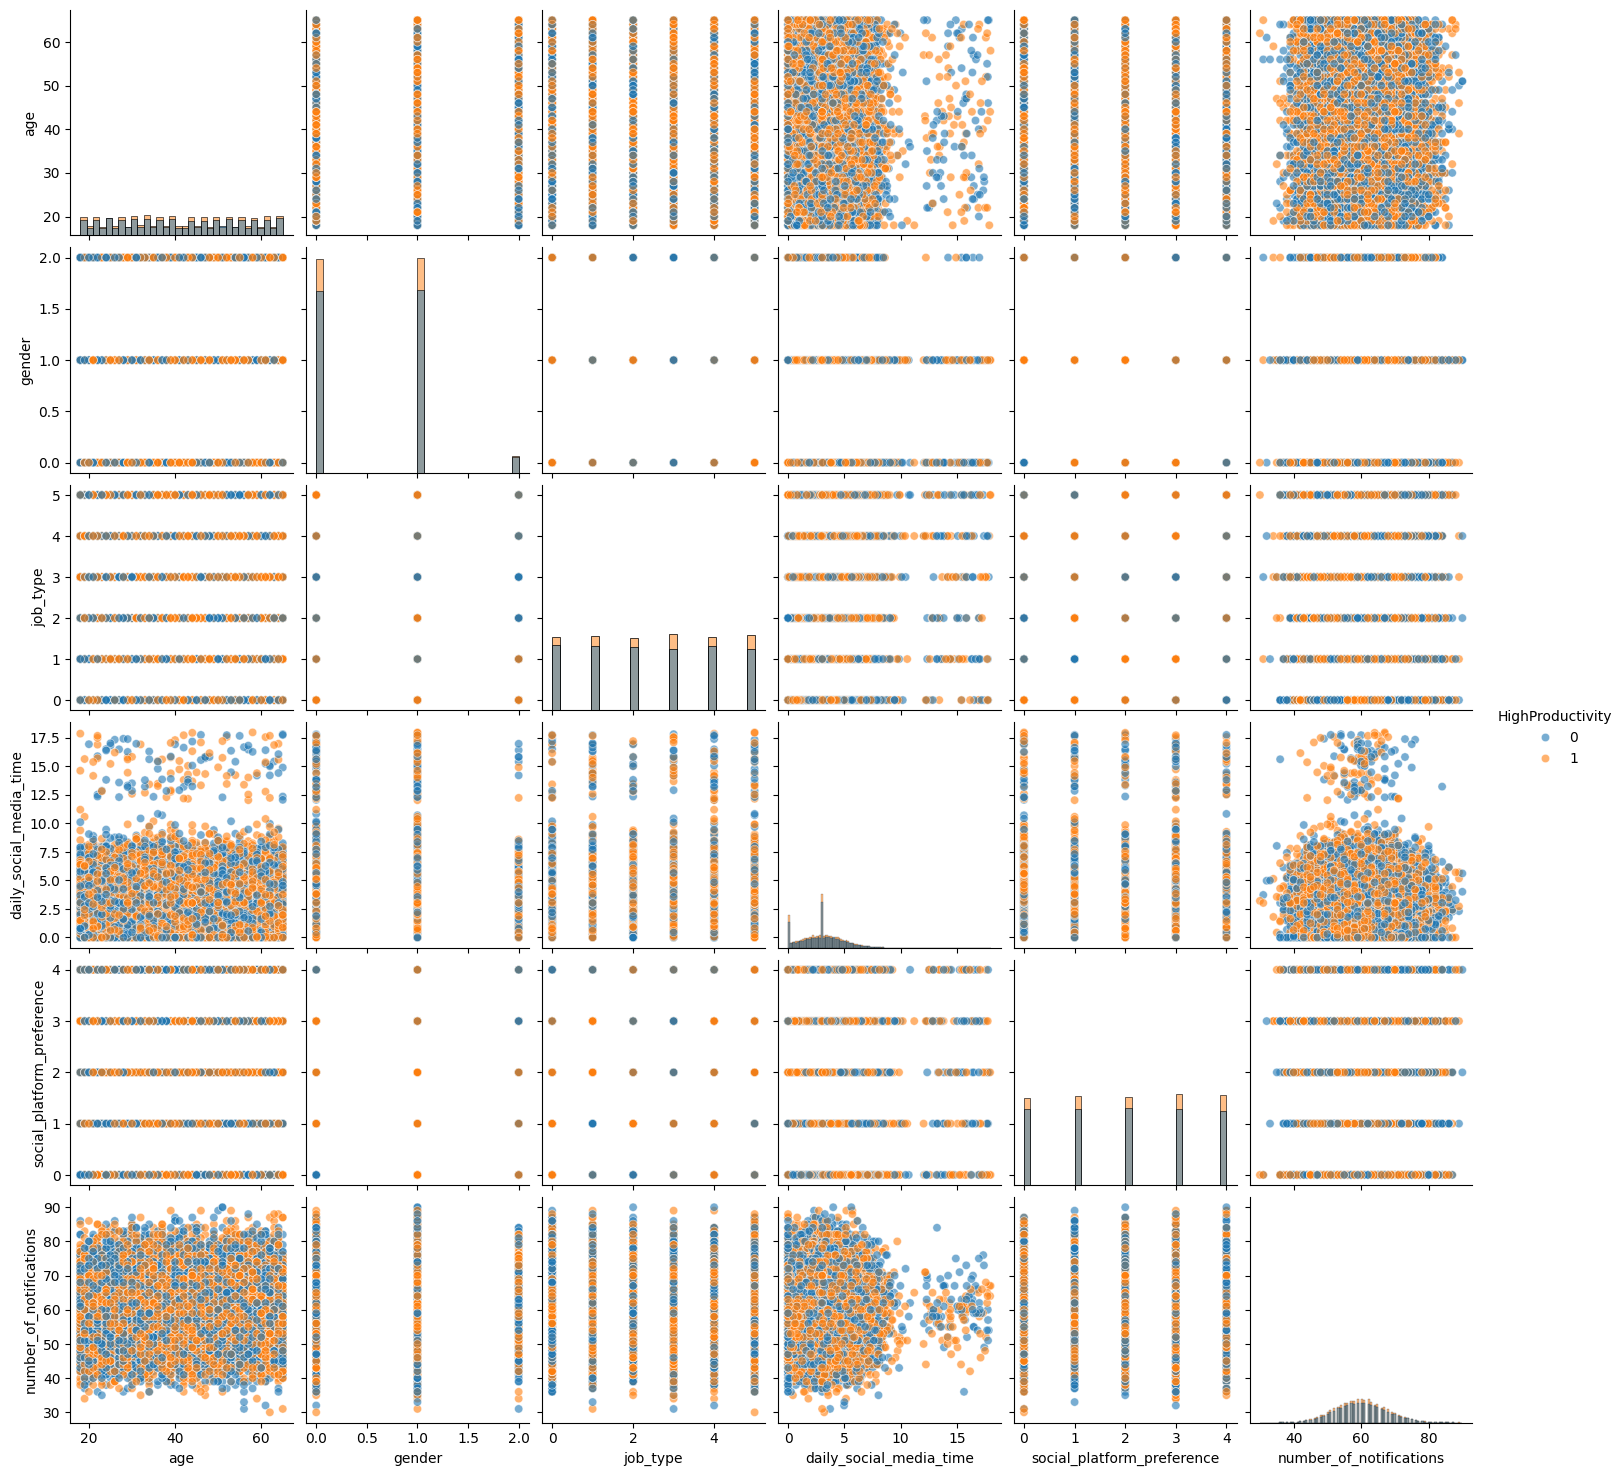

In [ ]:
pair_cols = numeric_features[:6] + ['HighProductivity'] if len(numeric_features) >= 6 else numeric_features + ['HighProductivity']
try:
    sns.pairplot(df_clean[pair_cols], hue='HighProductivity', diag_kind='hist', plot_kws={'alpha':0.6})
    plt.savefig('pairplot_selected.png')
    plt.show()
except Exception as e:
    print(' Pairplot skipped (too heavy) or error:', e)

### Target class distribution

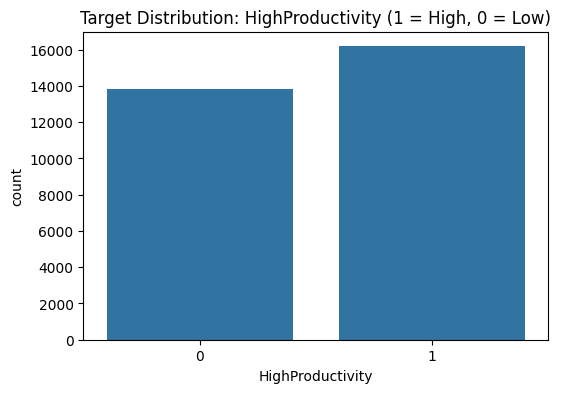

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='HighProductivity', data=df_clean)
plt.title('Target Distribution: HighProductivity (1 = High, 0 = Low)')
plt.savefig('target_distribution.png')
plt.show()

## STEP 6: FEATURE SELECTION & SCALING


In [6]:
print('\n--- Feature Selection & Scaling ---')
X = df_clean.drop(columns=['HighProductivity'])
y = df_clean['HighProductivity']

# Create a scaler for numeric columns only (cat already encoded as ints)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])

print(' Features scaled. X shape:', X_scaled.shape)



--- Feature Selection & Scaling ---
 Features scaled. X shape: (30000, 19)


## STEP 7: UNSUPERVISED SEGMENTATION (K-Means + PCA for visualization)


--- K-Means Clustering ---


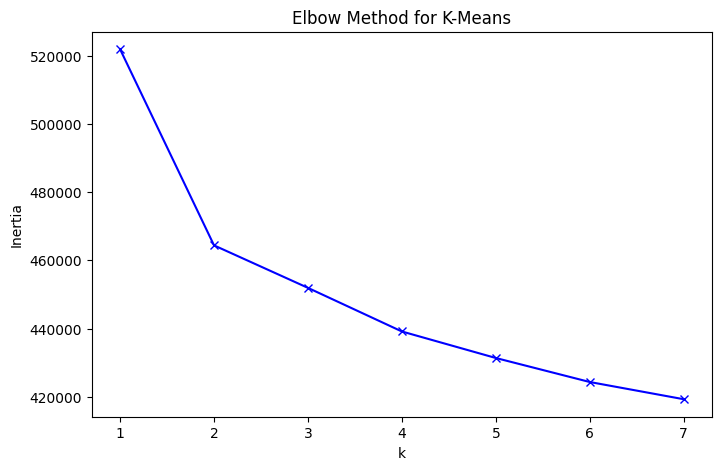

 K-Means done with k=3. Cluster counts:
Cluster
2    13259
1     8469
0     8272
Name: count, dtype: int64


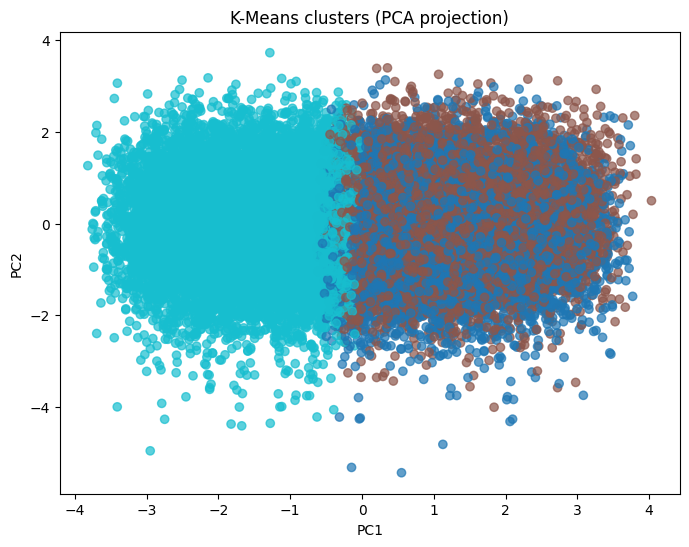

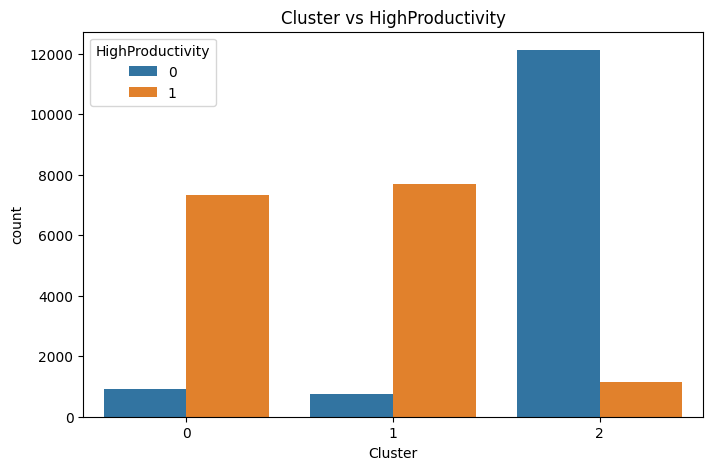

In [7]:
print('\n--- K-Means Clustering ---')
# find elbow
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(list(K), inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.savefig('kmeans_elbow.png')
plt.show()

# choose k=3 by default (change if needed)
k_opt = 3
km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters = km.fit_predict(X_scaled)
df_clean['Cluster'] = clusters
print(f' K-Means done with k={k_opt}. Cluster counts:')
print(df_clean['Cluster'].value_counts())

# PCA for 2D plot
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('K-Means clusters (PCA projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('kmeans_pca.png')
plt.show()

# cluster vs target
plt.figure(figsize=(8,5))
sns.countplot(x='Cluster', hue='HighProductivity', data=df_clean)
plt.title('Cluster vs HighProductivity')
plt.savefig('cluster_vs_target.png')
plt.show()



## STEP 8: TRAIN-TEST SPLIT


In [8]:
print('\n--- Train-Test Split ---')
X_final = X_scaled.copy()
# drop cluster from features if present
if 'Cluster' in X_final.columns:
    X_final = X_final.drop(columns=['Cluster'])

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


--- Train-Test Split ---
Train shape: (24000, 19) Test shape: (6000, 19)


## STEP 8.1 : Model Training with Hyperparameter Tuning and ROC Curve


 Tuning LogisticRegression...
Best Params for LogisticRegression: {'C': 10, 'solver': 'lbfgs'}
 Test F1 Score: 0.99  | ROC-AUC: 1.00
 Saved as best_model.joblib


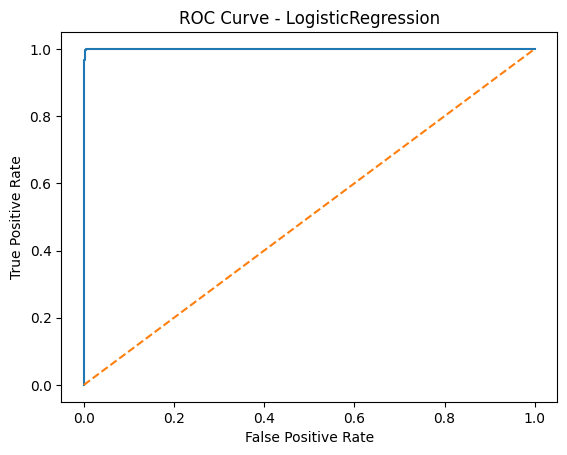


 Tuning KNN...
Best Params for KNN: {'n_neighbors': 9, 'weights': 'uniform'}
 Test F1 Score: 0.91  | ROC-AUC: 0.97


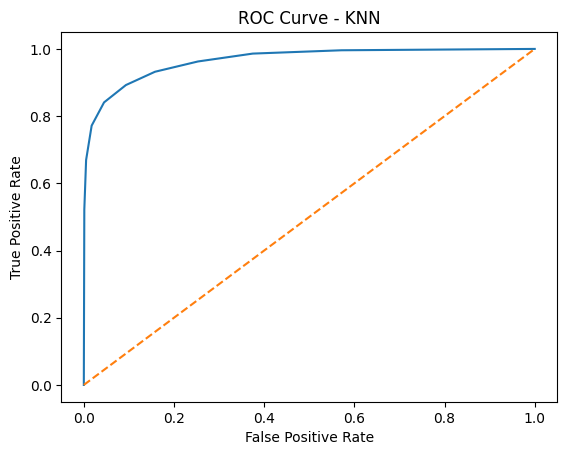


 Tuning SVM...
Best Params for SVM: {'C': 10, 'kernel': 'rbf'}
 Test F1 Score: 0.98  | ROC-AUC: 1.00


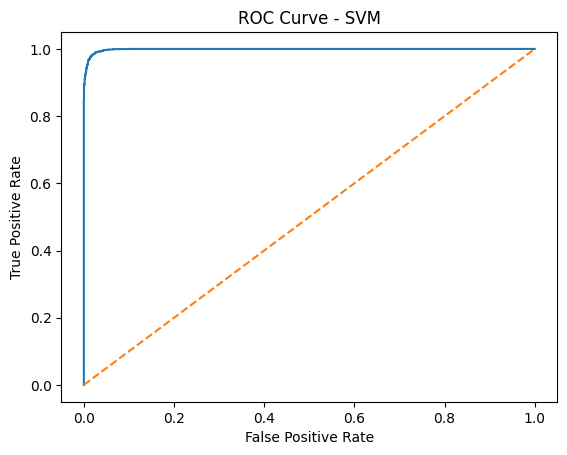


 Tuning RandomForest...
Best Params for RandomForest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
 Test F1 Score: 1.00  | ROC-AUC: 1.00
 Saved as best_model.joblib


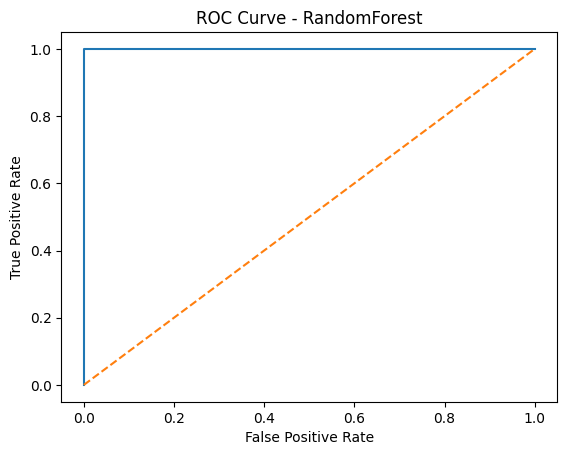


 Tuning Completed!


In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from joblib import dump, load
best_model = None
best_f1 = 0
results = {}

# Hyperparameter grids
param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'poly']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5]
    }
}

models = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier()
}

for name, model in models.items():
    print(f"\n Tuning {name}...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid[name],
        cv=StratifiedKFold(n_splits=3),
        scoring='f1',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)

    best_clf = grid.best_estimator_
    y_pred = best_clf.predict(X_test)
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'model': best_clf,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc': roc
    }

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f" Test F1 Score: {f1:.2f}  | ROC-AUC: {roc:.2f}")

    # Save the best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = best_clf
        dump(best_model, "newbest_model.joblib")
        print(" Saved as best_model.joblib")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.savefig(f"ROC_{name}.png")
    plt.show()

print("\n Tuning Completed!")


## STEP 9: MODEL TRAINING & EVALUATION



--- Training LogisticRegression ---
LogisticRegression Accuracy: 0.99, Precision: 0.97, Recall: 1.00, F1: 0.99, ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2763
           1       0.97      1.00      0.99      3237

    accuracy                           0.99      6000
   macro avg       0.99      0.98      0.99      6000
weighted avg       0.99      0.99      0.99      6000



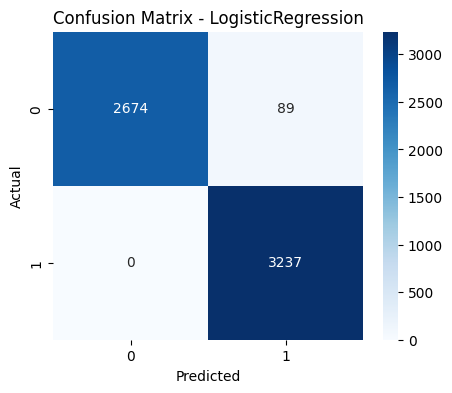


--- Training KNN ---
KNN Accuracy: 0.89, Precision: 0.90, Recall: 0.88, F1: 0.89, ROC-AUC: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2763
           1       0.90      0.88      0.89      3237

    accuracy                           0.89      6000
   macro avg       0.88      0.89      0.88      6000
weighted avg       0.89      0.89      0.89      6000



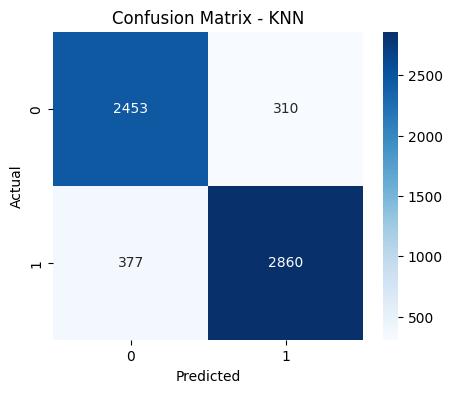


--- Training SVM ---
SVM Accuracy: 0.98, Precision: 0.96, Recall: 1.00, F1: 0.98, ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2763
           1       0.96      1.00      0.98      3237

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



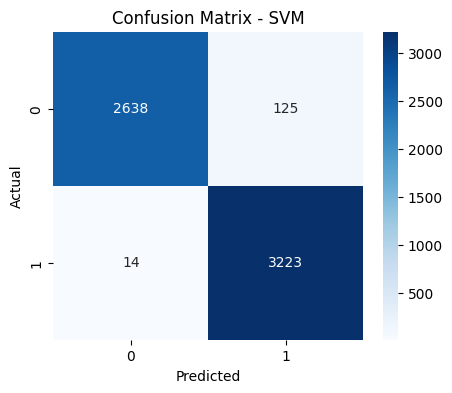


--- Training RandomForest ---
RandomForest Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1: 1.00, ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2763
           1       1.00      1.00      1.00      3237

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



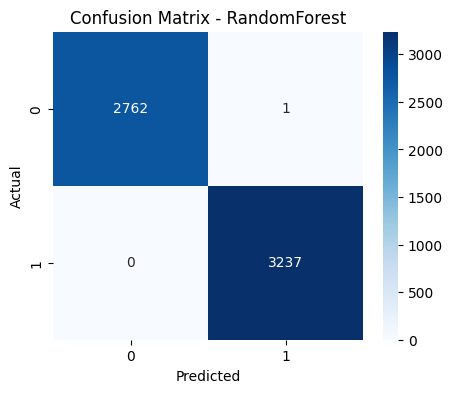


Model comparison:


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,RandomForest,0.999833,0.999691,1.000000,0.999846,1.000000
0,LogisticRegression,0.985167,0.973241,1.000000,0.986439,0.999708
2,SVM,0.976833,0.962664,0.995675,0.978891,0.998595
1,KNN,0.885500,0.902208,0.883534,0.892774,0.953977


In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'y_pred': y_pred
    }

    roc_text = f"{roc:.2f}" if roc is not None else "NA"
    print(
        f"{name} Accuracy: {acc:.2f}, Precision: {prec:.2f}, "
        f"Recall: {rec:.2f}, F1: {f1:.2f}, ROC-AUC: {roc_text}"
    )

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_{name}.png')
    plt.show()

# Summary table
summary = pd.DataFrame([{ 'Model': k,
                          'Accuracy': v['accuracy'],
                          'Precision': v['precision'],
                          'Recall': v['recall'],
                          'F1': v['f1'],
                          'ROC_AUC': v['roc_auc'] }
                        for k,v in results.items()])

print('\nModel comparison:')
display(summary.sort_values(by='F1', ascending=False))

## STEP 10: CROSS-VALIDATION (StratifiedKFold)


In [11]:
print('\n--- Cross-validation (StratifiedKFold) ---')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, m in models.items():
    scores = cross_val_score(m, X_final, y, cv=skf, scoring='f1')
    cv_results[name] = scores
    print(f"{name} F1 CV scores: {scores}, mean={scores.mean():.4f}")


--- Cross-validation (StratifiedKFold) ---
LogisticRegression F1 CV scores: [0.98389058 0.98734177 0.98839695 0.98748856 0.98403527], mean=0.9862
KNN F1 CV scores: [0.90084191 0.90040971 0.8933375  0.89531594 0.89940644], mean=0.8979
SVM F1 CV scores: [0.9785109  0.98321123 0.98008816 0.98006392 0.97771039], mean=0.9799
RandomForest F1 CV scores: [1.         1.         0.99984556 1.         0.99984551], mean=0.9999


## STEP 11: FEATURE IMPORTANCE (Random Forest)


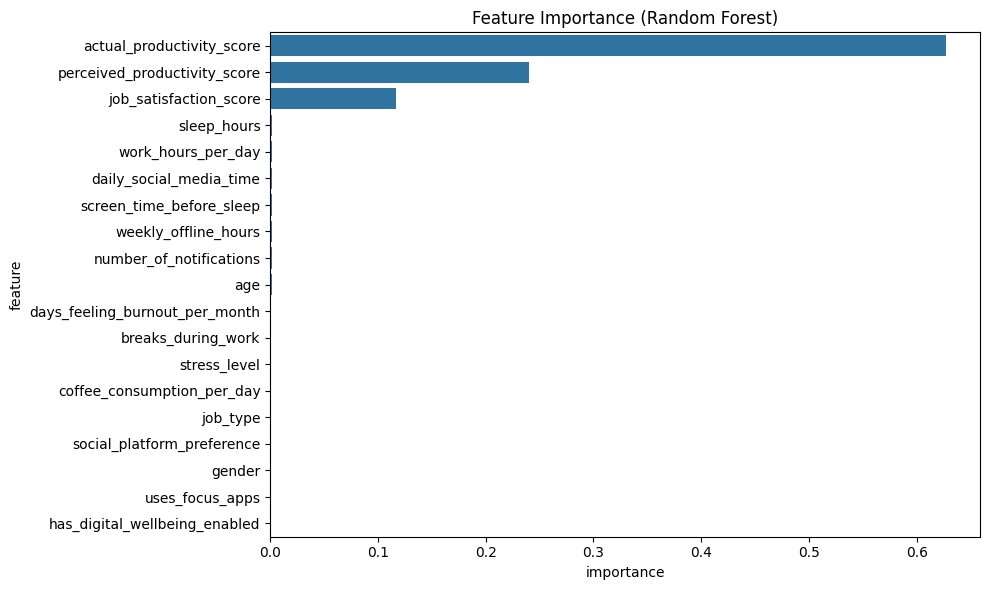

In [12]:
if 'RandomForest' in results:
    rf = results['RandomForest']['model']
    try:
        importances = rf.feature_importances_
        feat_names = X_final.columns
        fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x='importance', y='feature', data=fi_df)
        plt.title('Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.savefig('feature_importance_rf.png')
        plt.show()
    except Exception as e:
        print('Could not compute feature importances:', e)

## STEP 12: DECISION BOUNDARY (2-feature visualization)


Top 2 features for visualization: ['actual_productivity_score', 'perceived_productivity_score']


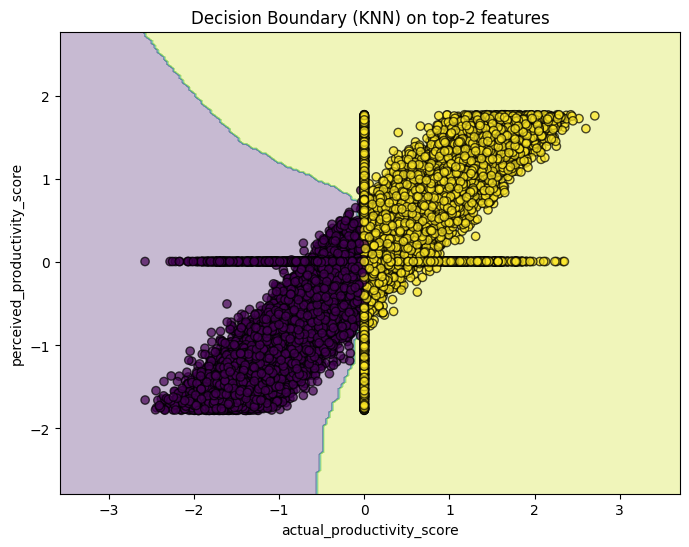

In [13]:
try:
    top2 = fi_df['feature'].values[:2].tolist()
    print('Top 2 features for visualization:', top2)
    X_vis = X_final[top2].values
    clf = KNeighborsClassifier(n_neighbors=5).fit(X_vis, y.values)

    # plot
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_vis[:,0], X_vis[:,1], c=y, edgecolor='k', alpha=0.7)
    plt.xlabel(top2[0])
    plt.ylabel(top2[1])
    plt.title('Decision Boundary (KNN) on top-2 features')
    plt.savefig('decision_boundary_top2.png')
    plt.show()
except Exception as e:
    print('Decision boundary plot skipped:', e)

## STEP 13: BAYESIAN NETWORK (Structure Learning)



--- Improved Bayesian Network Structure Learning (pgmpy) ---


  0%|          | 3/1000 [00:00<02:58,  5.59it/s]


 Learned BN edges: [('perceived_productivity_score', 'actual_productivity_score'), ('perceived_productivity_score', 'HighProductivity'), ('actual_productivity_score', 'HighProductivity')]


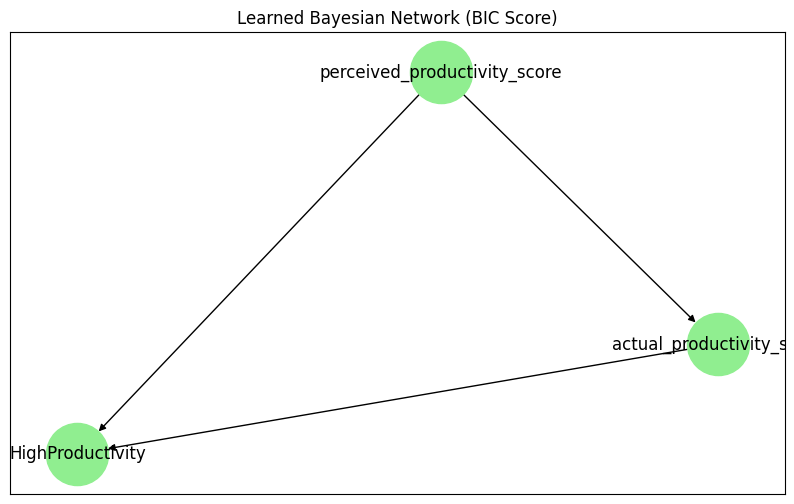

 Bayesian network graph saved as bayesian_network_structure.png


In [14]:
try:
    print("\n--- Improved Bayesian Network Structure Learning (pgmpy) ---")

    from pgmpy.estimators import HillClimbSearch, BicScore
    import networkx as nx
    import matplotlib.pyplot as plt

    # pick more features (up to 10)
    bn_cols = (numeric_cols + cat_cols)[:10]
    df_bn = df_clean[bn_cols + ['HighProductivity']].copy()

    # Discretize ALL numeric variables into 4 equal-width bins
    for c in df_bn.select_dtypes(include=['int64', 'float64']).columns:
        df_bn[c] = pd.cut(df_bn[c], bins=4, labels=False)

    # Convert everything to categorical
    for c in df_bn.columns:
        df_bn[c] = df_bn[c].astype('category')

    # Structure learning using BIC (often better than K2)
    hc = HillClimbSearch(df_bn)
    scoring = BicScore(df_bn)

    best_model = hc.estimate(
        scoring_method=scoring,
        max_indegree=4,
        max_iter=1000,
        black_list=None,
        white_list=None
    )

    edges = list(best_model.edges())
    print(" Learned BN edges:", edges)

    if len(edges) > 0:
        G = nx.DiGraph()
        G.add_edges_from(edges)

        plt.figure(figsize=(10,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw_networkx(G, pos=pos, with_labels=True,
                        node_size=2000, node_color='lightgreen')
        plt.title("Learned Bayesian Network (BIC Score)")
        plt.savefig("bayesian_network_structure.png")
        plt.show()

        print(" Bayesian network graph saved as bayesian_network_structure.png")
    else:
        print(" Still no edges. This means your data has weak conditional dependencies.")
        print(" Try these fixes:\n"
                "- Increase bins to 5 or 6\n"
                "- Increase number of features\n"
                "- Remove perfectly correlated features")

except Exception as e:
    print(" Bayesian Network step failed:", e)
